# Short-term Load Forcasting using machine learning

### Notebook by [Sifang Zhao]

## Table of contents

1. [Introduction](#Introduction)

2. [Required Libraries](#Required-Libraries)

3. [The Problem Domain](#The-Problem-Domain)

4. [Step 1: Data Overview](#Step-1:-Data-Overview)

    - [Load Dataset](#Load-Dataset)
    - [View Data](#View-Data)
    - [Data Preparation](#Data-Preparation)

5. [Step 2: Univariant Prediction](#Step-2:-Univariant-Prediction)

    - [Parameter Definition](#Parameter-Definition)
    - [Data Engineering](#Data-Engineering)
    - [Build Model](#Build-Model)
    - [Model Training](#Model-Training)
    - [Result Evaluation](#Result-Evaluation)

6. [Step 3: Multi-variants Prediction](#Step-3:-Multi-variants-Prediction)

7. [Step 4: Uni-variant and Multi-variants Day-ahead Prediction](#Step-4:-Uni-variant-and-Multi-variants-Day-ahead-Prediction)

8. [Step 5: Result Analysis](#Step-5:-Result-Analysis)

9. [Step 6: Reproducibility](#Step-6:-Reproducibility)


## Introduction
[[ go back to the top ]](#Table-of-contents)

Electric load forecasting has a significant role in power grids in order to facilitate the decision making process of energy generation & consumption. The behaviour of electric load time series is very non-linear and seasonal, Neural Networks are best suited model for learning the non-linear behavior within the data and for forcasting purposes. In this notebook, the focus is on Short-term Load Forecasting, which means we are using the previous data to predict the loading for the next hour or next day.  

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are installed and imported below:

In [0]:
# Install external packages.
!pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [0]:
# Import required libraries.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# Enable eagor execution.
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense

# Show plots inside of the notebook.
%matplotlib inline
import matplotlib.pyplot as plt

## The Problem Domain
[[ go back to the top ]](#Table-of-contents)

 In this notebook, RNN model with LSTM is used to complete the following tasks:
 1. Univariant model to predict single future point.
 2. Multi-variant model to predict single future point.
 3. Multi-variant model to predict multiple future points.

## Step 1: Data Overview
[[ go back to the top ]](#Table-of-contents)

### Load Dataset
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Load from local drive
# df=pd.read_csv('malaysia_all_data_for_paper.csv', sep=';', index_col='time', parse_dates=True) 

file_id='1VTPXEplsH1qXQGXa5RA8AX0hGnsnrIH5' 
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
df = pd.read_csv(csv_url, sep=';', index_col='time', parse_dates=True)

### View Data
[[ go back to the top ]](#Table-of-contents)

In [0]:
df.head()

,temperature,load
time,,
2009-01-01 01:00:00,24,30360
2009-01-01 02:00:00,24,29155
2009-01-01 03:00:00,24,28086
2009-01-01 04:00:00,24,28031
2009-01-01 05:00:00,24,27730


In [0]:
df.shape

(17519, 2)

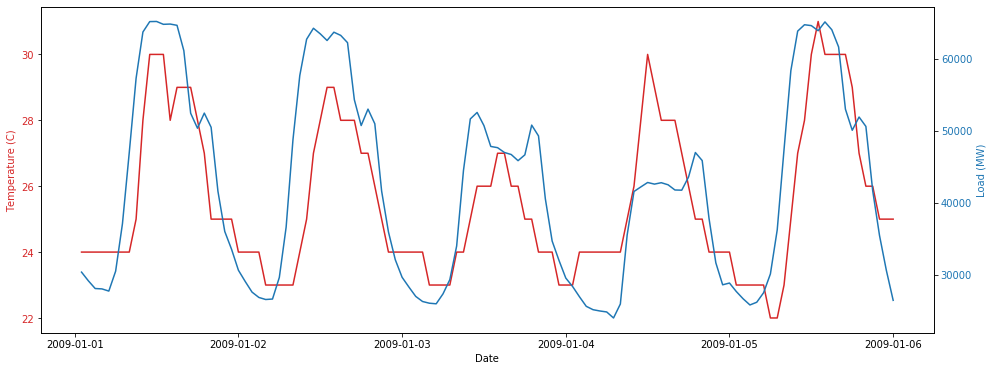

In [0]:
# View data distribution.
fig, ax1 = plt.subplots(figsize=(16, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (C)', color=color)
ax1.plot(df['temperature'][:120], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color='tab:blue'
ax2.set_ylabel('Load (MW)', color=color)
ax2.plot(df['load'][:120], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

The dataset is 730 days of temperature and loading data for 24 entries a day (1 sample/hour). As we can see from the plots, there's a strong correlation between temperature and loading.

### Data Preparation
[[ go back to the top ]](#Table-of-contents)

We apply Min-Max Normalization to the dataset. The reason to use Min-Max Normalization instead of Standardization is that we care more about loading at peak to avoid power outage. 

In [0]:
# Function for Min-Max Normalization.
def min_max_norm(dataset_train, dataset_test):
    """
    Min-Max Normalization.

    Parameters
    ----------
    dataset_train: Train data.
    dataset_test: Test data.

    Returns
    -------
    Normalized datasets. 

    """
    dataset_max = dataset_train.max()
    dataset_min = dataset_train.min()
    
    dataset_train_std = (dataset_train - dataset_min)/(dataset_max - dataset_min)
    dataset_test_std = (dataset_test - dataset_min)/(dataset_max - dataset_min)
    
    return dataset_train_std, dataset_test_std

In [0]:
# Function to reshape the data to feed into RNN model.
def reshape(dataset, target, history_step, target_step, single_step=False):
    """
    Reshape the data to RNN model accepted dimension. 
    
    Parameters
    ----------
    dataset: Original input dataset X.
    target: Output dataset y.
    history_step: Length of history steps used as model input. 
    target_step: Steps to predict from the end index of one input set. 
    single_step: If single_step=True, output y is one value at end_index + target_step.
                 If single_step=False, output y is a list of value from end_index to end_index + target_step.

    Returns
    -------
    x: Reshaped x.
    y: Reshaped y.
    """
    n = dataset.shape[0]
    if len(dataset.shape) == 1:
        num_features = 1
    else:
        num_features = dataset.shape[1]
    x, y = [], []
    
    x_start_index, x_end_index = 0, n - history_step - target_step
    
    for i in range(x_start_index, x_end_index):
        indices = range(i, i + history_step)
        x.append(np.reshape(dataset[indices], (history_step, num_features)))
        if single_step:
            y.append(target[i + history_step + target_step])
        else:
            y.append(target[i + history_step: i + history_step + target_step])
    
    return np.array(x), np.array(y)

In [0]:
# Train test split. The last 20% of data are used for testing.
TEST_SPLIT = int(df.shape[0] * 0.8)
df_train, df_test = df[:TEST_SPLIT], df[TEST_SPLIT:]
df_train_std, df_test_std = min_max_norm(df_train, df_test)

## Step 3: Univariant Prediction
[[ go back to the top ]](#Table-of-contents)

### Parameter Definition
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Use input data from previous 24 hours to predict next hour loading.
history_step = 24 
target_step = 0

# Batch parameters.
val_split=0.8
batch_size=256
buffer_size=10000

# RNN model parameters.
layers = 2
num_unit = 16
EVALUATION_INTERVAL = 100
EPOCHS = 50
VALIDATION_STEPS = 20

### Data Engineering
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Only use loading column for prediction.
uni_train_std, uni_test_std = df_train_std['load'].values, df_test_std['load'].values

# Prepare X, y for training.
x_train_uni, y_train_uni = reshape(uni_train_std, uni_train_std, history_step, target_step, single_step=True)
x_test_uni, y_test_uni = reshape(uni_test_std, uni_test_std, history_step, target_step, single_step=True)

In [0]:
# Verify reshaped dataset shape:
print('Training X, y dataset shapes are:')
print(x_train_uni.shape, y_train_uni.shape)
print('Testing X, y dataset shapes are:')
print(x_test_uni.shape, y_test_uni.shape)

Training X, y dataset shapes are:
(13991, 24, 1) (13991,)
Testing X, y dataset shapes are:
(3480, 24, 1) (3480,)


In [0]:
# Function to shuffle and cache the train and validation data batch.
def data_batch(x, y, val_split=0.8, batch_size=256, buffer_size=10000):
    
    split_index = int(x.shape[0] * val_split)
    
    train = tf.data.Dataset.from_tensor_slices((x[:split_index], y[:split_index]))
    validation = tf.data.Dataset.from_tensor_slices((x[split_index:], y[split_index:]))
    
    # Construct batch data.
    train_batch = train.cache().shuffle(buffer_size).batch(batch_size).repeat()
    val_batch = validation.cache().shuffle(buffer_size).batch(batch_size).repeat()

    return train_batch, val_batch

In [0]:
# Train and validation batch
train_batch, val_batch = data_batch(x_train_uni, y_train_uni)

### Build Model
[[ go back to the top ]](#Table-of-contents)

In [0]:
def lstm_model(layers, num_unit, input_shape, output_size, optimizer='adam', loss='mae'):
    """
    Construct RNN model with LSTM cell
    
    Parameters
    ----------
    layers: layers of LSTM in the model.
    num_unit: Positive integer, dimensionality of the output space.
    input_shape: 
    output_size: 
    optimizer:
    loss:

    Returns
    -------
    LSTM model.
    """
    model = tf.keras.models.Sequential()
    
    for i in range(layers - 1):
        model.add(LSTM(num_unit, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(num_unit, input_shape=input_shape))
    model.add(Dense(output_size))                    # Output layer.
    
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

In [0]:
# Univariant model.
uni_model = lstm_model(layers, num_unit, x_train_uni.shape[-2:], target_step+1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Model Training
[[ go back to the top ]](#Table-of-contents)

In [0]:
uni_history = uni_model.fit(train_batch, 
                             epochs=EPOCHS,
                             steps_per_epoch=EVALUATION_INTERVAL,
                             validation_data=val_batch, 
                             validation_steps=VALIDATION_STEPS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100 steps, validate on 20 steps
Epoch 1/50
100/100 [==============================] - 6s 56ms/step - loss: 0.2319 - val_loss: 0.1474
Epoch 2/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0893 - val_loss: 0.0614
Epoch 3/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0573 - val_loss: 0.0510
Epoch 4/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0514 - val_loss: 0.0457
Epoch 5/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0464 - val_loss: 0.0479
Epoch 6/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0431 - val_loss: 0.0419
Epoch 7/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0418 - val_loss: 0.0425
Epoch 8/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0399 - val_loss: 0.0391
Epoch 9/50
100/100 [==============================] - 4s 

### Model Tunning
[[ go back to the top ]](#Table-of-contents)

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

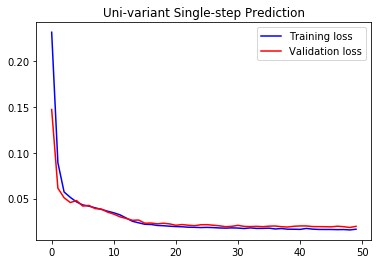

In [0]:
plot_train_history(uni_history, 'Uni-variant Single-step Prediction')

As we can see from the plot, after 20 epoches, the training loss decreases slowly and validation loss start to fluctuate. To aviod overfitting and reduce calculation time. We will add early stopping to the model.

In [0]:
# Early stopping.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.002,
                                           patience=3)

In [0]:
# Re-train model with early stopping added.
uni_model = lstm_model(layers, num_unit, x_train_uni.shape[-2:], target_step+1)

uni_history = uni_model.fit(train_batch, 
                            epochs=EPOCHS,
                            steps_per_epoch=EVALUATION_INTERVAL,
                            callbacks=[earlystop_callback],
                            validation_data=val_batch, 
                            validation_steps=VALIDATION_STEPS)

Train on 100 steps, validate on 20 steps
Epoch 1/50
100/100 [==============================] - 5s 55ms/step - loss: 0.2386 - val_loss: 0.1734
Epoch 2/50
100/100 [==============================] - 4s 43ms/step - loss: 0.1038 - val_loss: 0.0633
Epoch 3/50
100/100 [==============================] - 4s 42ms/step - loss: 0.0586 - val_loss: 0.0563
Epoch 4/50
100/100 [==============================] - 4s 42ms/step - loss: 0.0552 - val_loss: 0.0539
Epoch 5/50
100/100 [==============================] - 4s 42ms/step - loss: 0.0511 - val_loss: 0.0480
Epoch 6/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0463 - val_loss: 0.0434
Epoch 7/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0423 - val_loss: 0.0411
Epoch 8/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0389 - val_loss: 0.0387
Epoch 9/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0356 - val_loss: 0.0353
Epoch 10/50
100/100 [=============================

Model training stops after certain epoches to avoid overfitting.

### Result Evaluation
[[ go back to the top ]](#Table-of-contents)

In [0]:
def mse_calc(a, b):
    n = len(a)
    res = sum([(a[i] - b[i])**2 for i in range(n)]) / n
    return res

In [0]:
# Prediction on test dataset and calculate loss.
uni_pred = uni_model.predict(x_test_uni)

uni_mse = mse_calc(uni_pred, y_test_uni)

print('Mean Square Error on test data is: %4f' % uni_mse)

Mean Square Error on test data is: 0.001508


We can generate a plot to compare predicted value from model with actual value.

In [0]:
# Function to generate comparison plot.

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

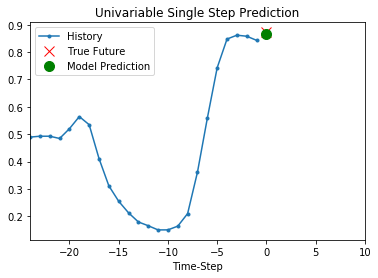

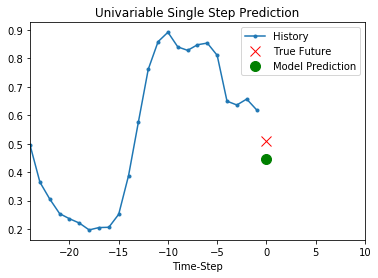

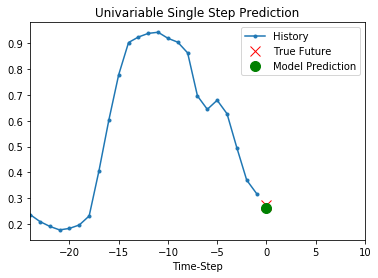

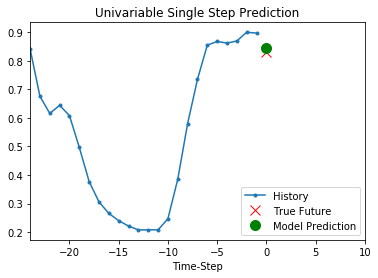

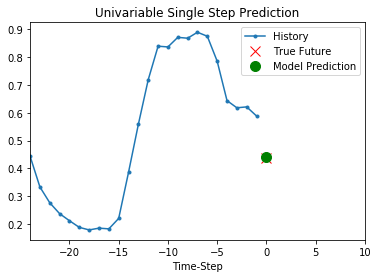

In [0]:
# Generate comparison plot for 5 random samples in testing dataset.
n = x_test_uni.shape[0]
rand = np.random.randint(n, size=5)

for i in rand:
    plot = show_plot([x_test_uni[i], y_test_uni[i], uni_pred[i]], 0, 'Univariable Single Step Prediction')
    plot.show()

## Step 3: Multi-variants Prediction
[[ go back to the top ]](#Table-of-contents)

### Parameter Defination
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Use same parameters as univariant prediction.
history_step = 24 
target_step = 0

# Batch parameters.
val_split=0.8
batch_size=256
buffer_size=10000

# RNN model parameters.
layers = 2
num_unit = 32
EVALUATION_INTERVAL = 100
EPOCHS = 50
VALIDATION_STEPS = 20

### Data Engineering
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Use all columns for prediction.
mul_train_std, mul_test_std = df_train_std.values, df_test_std.values

# Prepare X, y for training. Here only load columns is considered as target.
x_train_mul, y_train_mul = reshape(mul_train_std, mul_train_std[:, -1], history_step, target_step, single_step=True)
x_test_mul, y_test_mul = reshape(mul_test_std, mul_test_std[:, -1], history_step, target_step, single_step=True)

In [0]:
# Verify reshaped dataset shape:
print('Training X, y dataset shapes are:')
print(x_train_mul.shape, y_train_mul.shape)
print('Testing X, y dataset shapes are:')
print(x_test_mul.shape, y_test_mul.shape)

Training X, y dataset shapes are:
(13991, 24, 2) (13991,)
Testing X, y dataset shapes are:
(3480, 24, 2) (3480,)


In [0]:
# Train and validation batch
train_batch, val_batch = data_batch(x_train_mul, y_train_mul)

### Build Model
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Multi-variant model.
mul_model = lstm_model(layers, num_unit, x_train_mul.shape[-2:], target_step+1)

### Model Training
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Train model with early stopping.
mul_history = mul_model.fit(train_batch, 
                            epochs=EPOCHS,
                            steps_per_epoch=EVALUATION_INTERVAL,
                            callbacks=[earlystop_callback],
                            validation_data=val_batch, 
                            validation_steps=VALIDATION_STEPS)

Train on 100 steps, validate on 20 steps
Epoch 1/50
100/100 [==============================] - 8s 80ms/step - loss: 0.1792 - val_loss: 0.0846
Epoch 2/50
100/100 [==============================] - 6s 65ms/step - loss: 0.0692 - val_loss: 0.0559
Epoch 3/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0560 - val_loss: 0.0528
Epoch 4/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0514 - val_loss: 0.0479
Epoch 5/50
100/100 [==============================] - 6s 65ms/step - loss: 0.0437 - val_loss: 0.0405
Epoch 6/50
100/100 [==============================] - 7s 66ms/step - loss: 0.0392 - val_loss: 0.0378
Epoch 7/50
100/100 [==============================] - 7s 65ms/step - loss: 0.0346 - val_loss: 0.0340
Epoch 8/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0309 - val_loss: 0.0328
Epoch 9/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0265 - val_loss: 0.0232
Epoch 10/50
100/100 [=============================

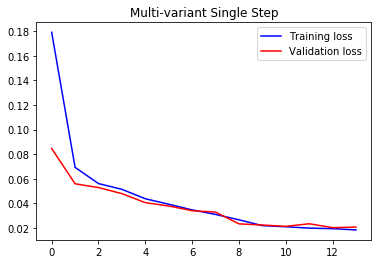

In [0]:
plot_train_history(mul_history, 'Multi-variant Single Step')

Model training stops after certain epoches to avoid overfitting.

### Result Evaluation
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Prediction on test dataset and calculate loss.
mul_pred = mul_model.predict(x_test_mul)

mul_mse = mse_calc(mul_pred, y_test_mul)

print('Mean Square Error on test data is: %4f' % mul_mse)

Mean Square Error on test data is: 0.001554


We can generate a plot to compare predicted value from model with actual value.

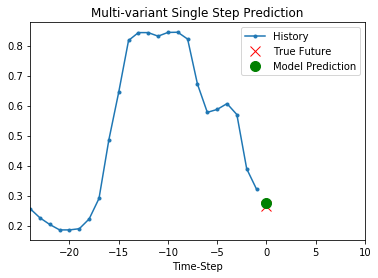

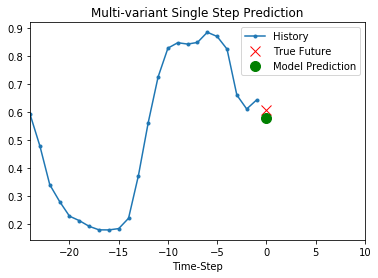

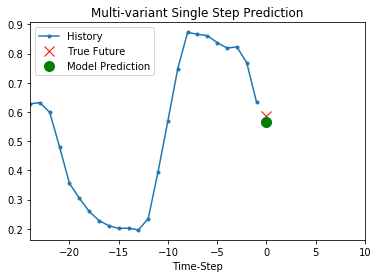

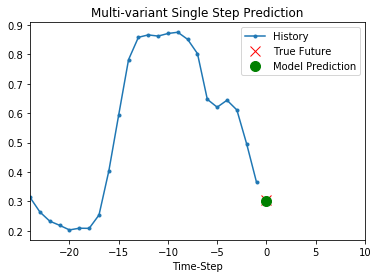

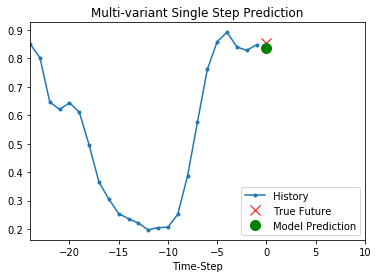

In [0]:
# Generate comparison plot for 5 random samples in testing dataset.
n = x_test_mul.shape[0]
rand = np.random.randint(n, size=5)

for i in rand:
    plot = show_plot([x_test_mul[i][:, -1], y_test_mul[i], mul_pred[i]], 0, 'Multi-variant Single Step Prediction')
    plot.show()

## Step 4: Uni-variant and Multi-variants Day-ahead Prediction
[[ go back to the top ]](#Table-of-contents)

### Parameter Defination
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Use same parameters as univariant prediction.
history_step = 168
target_step = 24    # Predict next day

# Batch parameters.
val_split=0.8
batch_size=256
buffer_size=10000

# RNN model parameters.
layers = 2
num_unit = 32
EVALUATION_INTERVAL = 200
EPOCHS = 50
VALIDATION_STEPS = 20

### Uni-variant model
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Prepare X, y for training.
x_train_uni, y_train_uni = reshape(uni_train_std, uni_train_std, history_step, target_step, single_step=False)
x_test_uni, y_test_uni = reshape(uni_test_std, uni_test_std, history_step, target_step, single_step=False)

# Verify reshaped dataset shape:
print('Training X, y dataset shapes are:')
print(x_train_uni.shape, y_train_uni.shape)
print('Testing X, y dataset shapes are:')
print(x_test_uni.shape, y_test_uni.shape)

# Train and validation batch
train_batch, val_batch = data_batch(x_train_uni, y_train_uni)


Training X, y dataset shapes are:
(13823, 168, 1) (13823, 24)
Testing X, y dataset shapes are:
(3312, 168, 1) (3312, 24)


In [0]:
# Build Model
uni_day_ahead_model = lstm_model(layers, num_unit, x_train_uni.shape[-2:], target_step, optimizer='RMSprop')

# Train model with early stopping.
uni_day_ahead_history = uni_day_ahead_model.fit(train_batch, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            callbacks=[earlystop_callback],
                                            validation_data=val_batch, 
                                            validation_steps=VALIDATION_STEPS)

Train on 200 steps, validate on 20 steps
Epoch 1/50
200/200 [==============================] - 88s 442ms/step - loss: 0.1430 - val_loss: 0.0862
Epoch 2/50
200/200 [==============================] - 87s 434ms/step - loss: 0.0875 - val_loss: 0.0809
Epoch 3/50
200/200 [==============================] - 87s 434ms/step - loss: 0.0817 - val_loss: 0.0831
Epoch 4/50
200/200 [==============================] - 86s 432ms/step - loss: 0.0756 - val_loss: 0.0708
Epoch 5/50
200/200 [==============================] - 87s 435ms/step - loss: 0.0714 - val_loss: 0.0650
Epoch 6/50
200/200 [==============================] - 87s 437ms/step - loss: 0.0681 - val_loss: 0.0735
Epoch 7/50
200/200 [==============================] - 88s 441ms/step - loss: 0.0655 - val_loss: 0.0614
Epoch 8/50
200/200 [==============================] - 87s 437ms/step - loss: 0.0628 - val_loss: 0.0610
Epoch 9/50
200/200 [==============================] - 88s 439ms/step - loss: 0.0604 - val_loss: 0.0605
Epoch 10/50
200/200 [===========

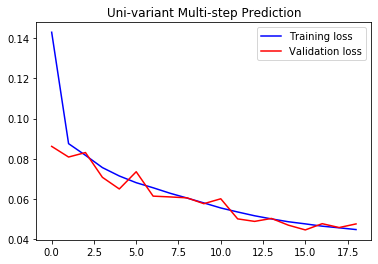

In [0]:
plot_train_history(uni_day_ahead_history, 'Uni-variant Multi-step Prediction')

In [0]:
# Plot function for multi-step model.
def multi_step_plot(history, true_future, prediction, title):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.title(title)
    plt.plot(num_in, np.array(history), '.-', label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'b-', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'r-', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

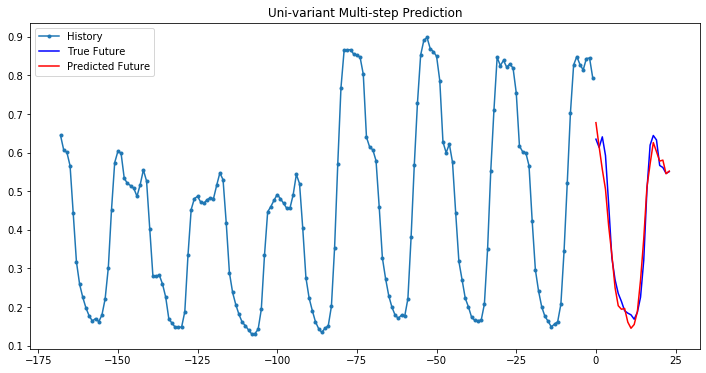

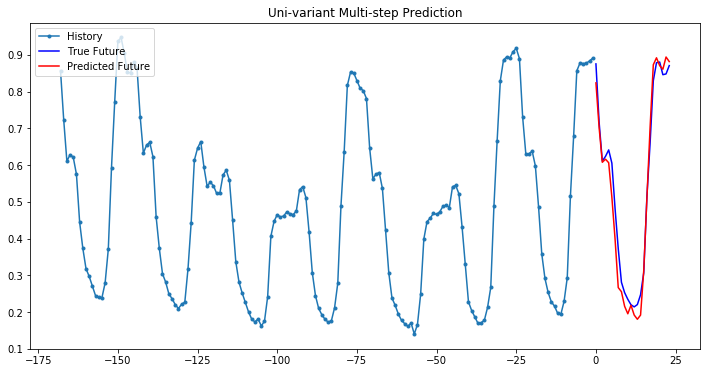

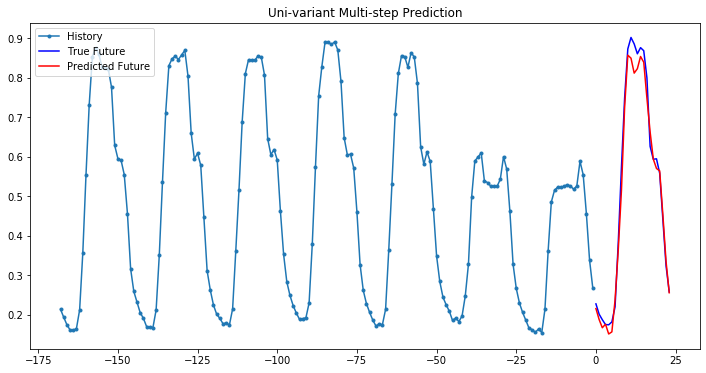

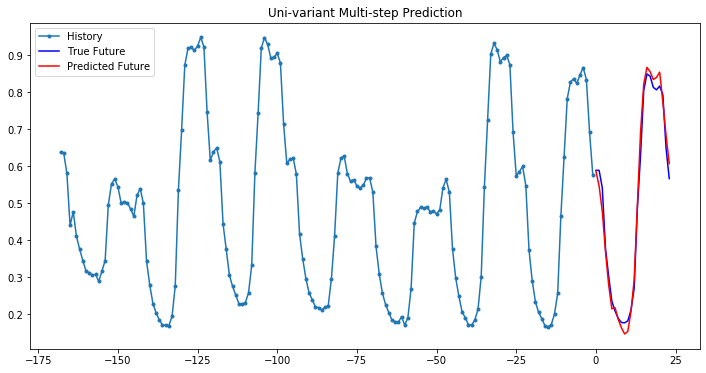

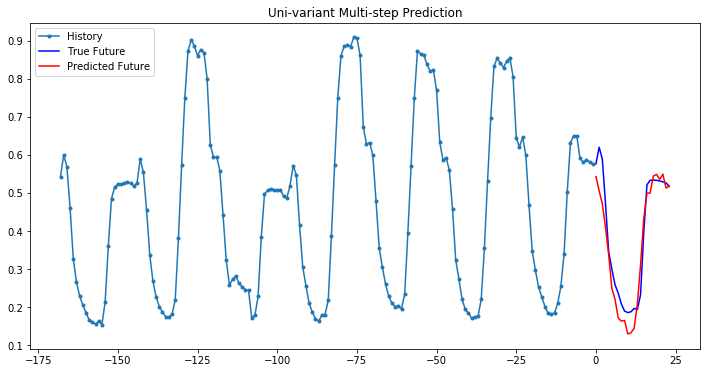

In [0]:
# Prediction
uni_day_ahead_pred = uni_day_ahead_model.predict(x_test_uni)

# Generate comparison plot for 5 random samples in testing dataset.
n = x_test_uni.shape[0]
rand = np.random.randint(n, size=5)

for i in rand:
    multi_step_plot(x_test_uni[i], y_test_uni[i], uni_day_ahead_pred[i], 'Uni-variant Multi-step Prediction')

### Multi-variant model
[[ go back to the top ]](#Table-of-contents)

In [0]:
# Prepare X, y for training.
x_train_mul, y_train_mul = reshape(mul_train_std, mul_train_std[:, -1], history_step, target_step, single_step=False)
x_test_mul, y_test_mul = reshape(mul_test_std, mul_test_std[:, -1], history_step, target_step, single_step=False)

# Verify reshaped dataset shape:
print('Training X, y dataset shapes are:')
print(x_train_mul.shape, y_train_mul.shape)
print('Testing X, y dataset shapes are:')
print(x_test_mul.shape, y_test_mul.shape)

# Train and validation batch
train_batch, val_batch = data_batch(x_train_mul, y_train_mul)


Training X, y dataset shapes are:
(13823, 168, 2) (13823, 24)
Testing X, y dataset shapes are:
(3312, 168, 2) (3312, 24)


In [0]:
# Build Model
mul_day_ahead_model = lstm_model(layers, num_unit, x_train_mul.shape[-2:], target_step, optimizer='RMSprop')

# Train model with early stopping.
mul_day_ahead_history = mul_day_ahead_model.fit(train_batch, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            callbacks=[earlystop_callback],
                                            validation_data=val_batch, 
                                            validation_steps=VALIDATION_STEPS)

Train on 200 steps, validate on 20 steps
Epoch 1/50
200/200 [==============================] - 89s 444ms/step - loss: 0.1398 - val_loss: 0.0917
Epoch 2/50
200/200 [==============================] - 87s 436ms/step - loss: 0.0881 - val_loss: 0.0865
Epoch 3/50
200/200 [==============================] - 88s 439ms/step - loss: 0.0822 - val_loss: 0.0869
Epoch 4/50
200/200 [==============================] - 88s 439ms/step - loss: 0.0785 - val_loss: 0.0733
Epoch 5/50
200/200 [==============================] - 87s 436ms/step - loss: 0.0730 - val_loss: 0.0759
Epoch 6/50
200/200 [==============================] - 88s 441ms/step - loss: 0.0678 - val_loss: 0.0669
Epoch 7/50
200/200 [==============================] - 89s 444ms/step - loss: 0.0627 - val_loss: 0.0572
Epoch 8/50
200/200 [==============================] - 88s 442ms/step - loss: 0.0582 - val_loss: 0.0525
Epoch 9/50
200/200 [==============================] - 88s 441ms/step - loss: 0.0554 - val_loss: 0.0600
Epoch 10/50
200/200 [===========

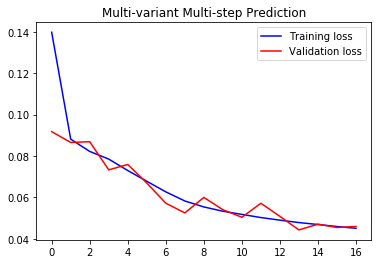

In [0]:
plot_train_history(mul_day_ahead_history, 'Multi-variant Multi-step Prediction')

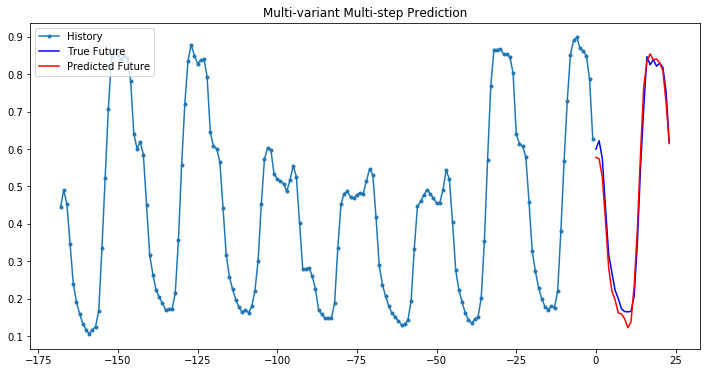

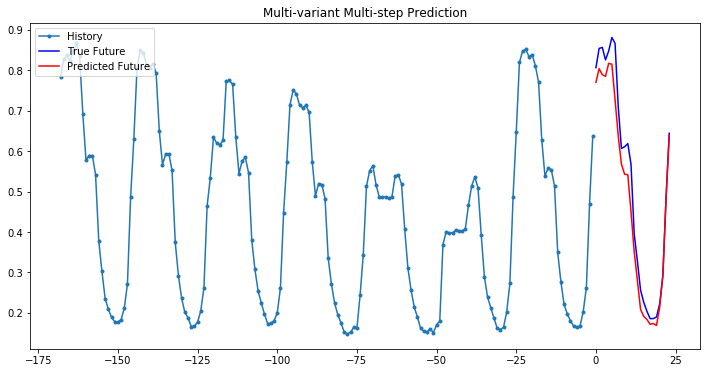

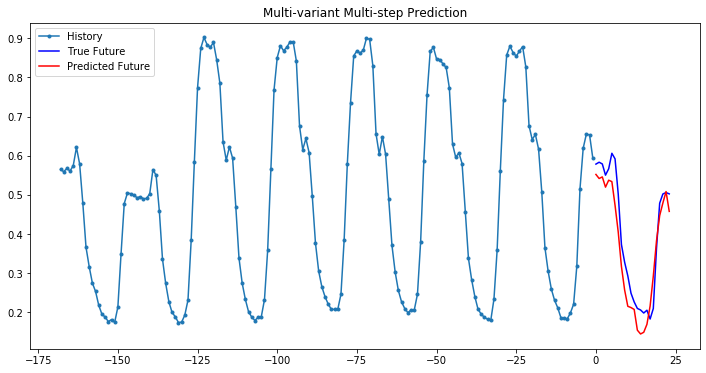

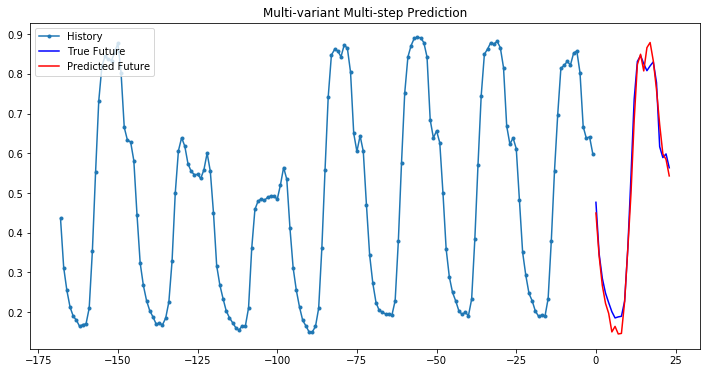

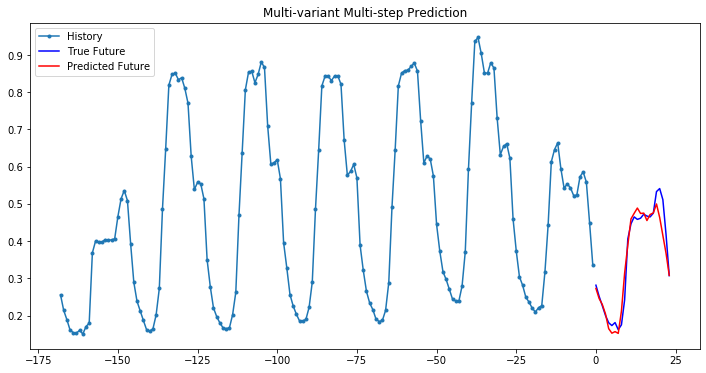

In [0]:
# Prediction
mul_day_ahead_pred = mul_day_ahead_model.predict(x_test_mul)

# Generate comparison plot for 5 random samples in testing dataset.
n = x_test_mul.shape[0]
rand = np.random.randint(n, size=5)

for i in rand:
    multi_step_plot(x_test_mul[i][:,1], y_test_mul[i], mul_day_ahead_pred[i], 'Multi-variant Multi-step Prediction')

## Step 5: Result Analysis

[[ go back to the top ]](#Table-of-contents)


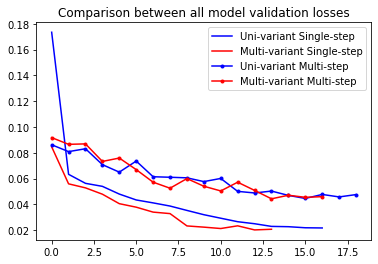

In [0]:
# Compare training process between all above methods.

histories = [uni_history, 
             mul_history, 
             uni_day_ahead_history, 
             mul_day_ahead_history]
styles = ['b', 'r', '.-b', '.-r']
labels = ['Uni-variant Single-step', 
          'Multi-variant Single-step', 
          'Uni-variant Multi-step', 
          'Multi-variant Multi-step']

plt.figure()

# plt.hold(True)
for i in range(len(histories)):
    val_loss = histories[i].history['val_loss']
    epochs = range(len(val_loss))
    plt.plot(epochs, val_loss, styles[i], label=labels[i])
plt.title('Comparison between all model validation losses')
plt.legend()

plt.show()
    

As we can see from the plot:
1. Multi-variant models produces better prediction performances.
2. Uni-variant models trains faster and are cost effective.
3. Single-step prediction has better performance than multi-step prediction which is as expected.

## Step 6: Reproducibility

[[ go back to the top ]](#Table-of-contents)

This notebook was created with the following environment:


In [0]:
# Time, version information
%watermark -a 'S.Zhao' -nmv -p numpy,pandas,matplotlib,tensorflow

S.Zhao Thu Dec 12 2019 

CPython 3.6.9
IPython 5.5.0

numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.2
tensorflow 1.15.0

compiler   : GCC 8.3.0
system     : Linux
release    : 4.14.137+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
